Task 9

In [ ]:
import numpy as np
from numpy.random import default_rng
from scipy.linalg import expm
import matplotlib.pyplot as plt

# lifelines is convenient for Kaplan–Meier; install once via
#   pip install lifelines
from lifelines import KaplanMeierFitter

In [ ]:
# ----------------------------------------------------------------------
# Utility functions
# ----------------------------------------------------------------------
def complete_diagonal(Q: np.ndarray) -> np.ndarray:
    Q = Q.copy()
    np.fill_diagonal(Q, 0.0)                       # clear any placeholder
    row_sums = Q.sum(axis=1)
    np.fill_diagonal(Q, -row_sums)
    return Q


def simulate_ctmc_lifetimes(Q: np.ndarray, n_sim: int, rng=None) -> np.ndarray:
    if rng is None:
        rng = default_rng()

    # Pre-compute helper structures for speed
    n_states = Q.shape[0]
    rates = -np.diag(Q)            # sojourn rates λ_i = −q_ii  (positive)
    jump_probs = np.where(Q > 0, Q, 0)  # positive off-diagonals
    jump_probs = jump_probs / rates[:, None]  # normalise rows

    lifetimes = np.empty(n_sim, dtype=float)

    for k in range(n_sim):
        state = 0          # Python index for state 1
        t = 0.0

        while state != 4:  # index 4 = state 5 (death, absorbing)
            # Draw sojourn time
            t += rng.exponential(scale=1.0 / rates[state])

            # Select next state according to jump probabilities
            next_state = rng.choice(n_states, p=jump_probs[state])
            state = next_state

        lifetimes[k] = t

    return lifetimes


def kaplan_meier(times: np.ndarray, label: str, ax=None):
    kmf = KaplanMeierFitter()
    kmf.fit(durations=times, event_observed=np.ones_like(times), label=label)

    if ax is not None:
        kmf.plot(ax=ax, ci_show=False)   # hide CI for clarity; add if desired

    return kmf

C:\Users\jorge\AppData\Local\Temp\ipykernel_40352\946206028.py:29: RuntimeWarning: invalid value encountered in divide
  jump_probs = jump_probs / rates[:, None]  # normalise rows


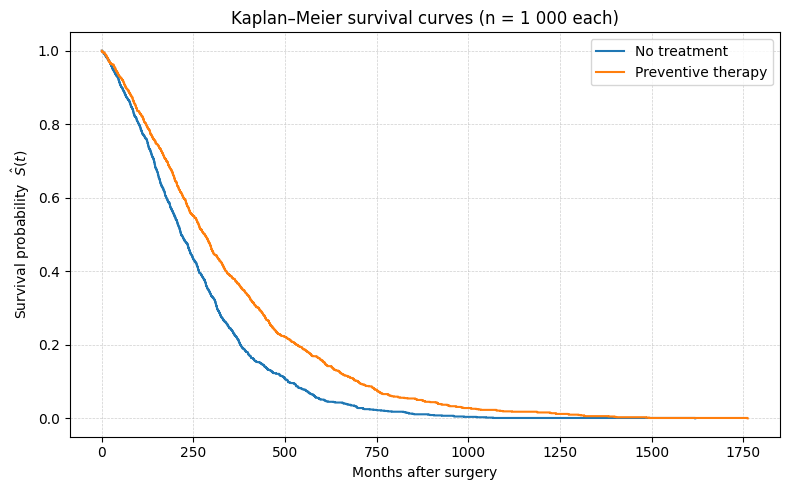

=== Lifetime summary (months) ===
No treatment      : mean = 257.37 (95 % CI 245.66 – 269.09), std = 189.01
Preventive therapy: mean = 343.21 (95 % CI 326.63 – 359.78), std = 267.40


'\nfrom lifelines.statistics import logrank_test\nresult = logrank_test(lifetimes_original, lifetimes_treatment,\n                      event_observed_A=np.ones_like(lifetimes_original),\n                      event_observed_B=np.ones_like(lifetimes_treatment))\nprint(result.summary)\n'

In [ ]:

# Q matrix from Task 7 (original – no treatment)
Q_original = np.array([
    [-0.0085, 0.005,   0.0025, 0.0,    0.001],
    [0.0,    -0.014,   0.005,  0.004,  0.005],
    [0.0,     0.0,    -0.008,  0.003,  0.005],
    [0.0,     0.0,     0.0,   -0.009,  0.009],
    [0.0,     0.0,     0.0,    0.0,    0.0  ]
])

# Preventive-treatment Q (diagonal asterisks replaced automatically)
Q_treatment = np.array([
    [np.nan, 0.0025,  0.00125, 0.0,    0.001],
    [0.0,    np.nan,  0.0,     0.002,  0.005],
    [0.0,    0.0,     np.nan,  0.003,  0.005],
    [0.0,    0.0,     0.0,     np.nan, 0.009],
    [0.0,    0.0,     0.0,     0.0,    0.0  ]
])

Q_treatment = complete_diagonal(Q_treatment)

# ----------------------------------------------------------------------
# Simulation parameters
# ----------------------------------------------------------------------
N_SIM = 1_000          # number of women per cohort
SEED  = 42             # reproducibility

rng = default_rng(SEED)

# ----------------------------------------------------------------------
# Simulations
# ----------------------------------------------------------------------
lifetimes_original  = simulate_ctmc_lifetimes(Q_original,  N_SIM, rng)
lifetimes_treatment = simulate_ctmc_lifetimes(Q_treatment, N_SIM, rng)

# ----------------------------------------------------------------------
# Kaplan-Meier curves
# ----------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))
km_orig  = kaplan_meier(lifetimes_original,  label="No treatment",      ax=ax)
km_trt   = kaplan_meier(lifetimes_treatment, label="Preventive therapy", ax=ax)

ax.set_xlabel("Months after surgery")
ax.set_ylabel("Survival probability  $\\hat S(t)$")
ax.set_title("Kaplan-Meier survival curves (n = 1 000 each)")
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# Quick descriptive statistics (mean & std with 95 % CI)
# ----------------------------------------------------------------------
def mean_ci(data, alpha=0.05):
    """Return mean and (lower, upper) two-sided CI assuming normality."""
    m = data.mean()
    s = data.std(ddof=1)
    z = 1.96   # 95 %
    half_width = z * s / np.sqrt(len(data))
    return m, (m - half_width, m + half_width), s, (s * np.sqrt((len(data)-1)/2) / np.sqrt(len(data)))

mean_o, ci_m_o, std_o, _ = mean_ci(lifetimes_original)
mean_t, ci_m_t, std_t, _ = mean_ci(lifetimes_treatment)

print("=== Lifetime summary (months) ===")
print(f"No treatment      : mean = {mean_o:6.2f} (95 % CI {ci_m_o[0]:.2f} – {ci_m_o[1]:.2f}), "
      f"std = {std_o:5.2f}")
print(f"Preventive therapy: mean = {mean_t:6.2f} (95 % CI {ci_m_t[0]:.2f} – {ci_m_t[1]:.2f}), "
      f"std = {std_t:5.2f}")


Task 10

In [4]:
# ----------------------------------------------------------------------
# (Optional) – Quick log-rank test (Task 10) for reference
# ----------------------------------------------------------------------

from lifelines.statistics import logrank_test
result = logrank_test(lifetimes_original, lifetimes_treatment,
                      event_observed_A=np.ones_like(lifetimes_original),
                      event_observed_B=np.ones_like(lifetimes_treatment))
print(result.summary)


   test_statistic             p   -log2(p)
0       73.683928  9.168235e-18  56.598062


Task 12

In [ ]:
import math
import numpy as np
from numpy.random import default_rng
from typing import List, Tuple

In [ ]:
# ---------------------------------------------------------------------
# Generator matrix Q  (original – no preventive treatment)
# ---------------------------------------------------------------------
Q = np.array([
    [-0.0085, 0.005,  0.0025, 0.0,   0.001],
    [0.0,    -0.014,  0.005,  0.004, 0.005],
    [0.0,     0.0,   -0.008,  0.003, 0.005],
    [0.0,     0.0,    0.0,   -0.009, 0.009],
    [0.0,     0.0,    0.0,    0.0,   0.0  ]]
)

# ---------------------------------------------------------------------
# Helper functions
# ---------------------------------------------------------------------
def _precompute(Q: np.ndarray):
    rates = -np.diag(Q)                       # λ_i = –q_ii  (positive)
    jump_probs = np.where(Q > 0, Q, 0)
    jump_probs = jump_probs / rates[:, None]  # normalise each row
    return rates, jump_probs


def simulate_ctmc_path(Q: np.ndarray, rng) -> Tuple[List[float], List[int]]:
    rates, jump_probs = _precompute(Q)

    t, state = 0.0, 0          # Python index 0 = state 1
    times  = [0.0]
    states = [1]

    while state != 4:          # index 4 ≡ state 5 (absorbing)
        sojourn = rng.exponential(scale=1.0 / rates[state])
        t += sojourn
        state = rng.choice(Q.shape[0], p=jump_probs[state])
        times.append(t)
        states.append(state + 1)   # back to 1-based labelling

    return times, states


def observation_sequence(times: List[float],
                         states: List[int],
                         interval: float = 48.0) -> List[int]:
    obs = []
    t_final = times[-1]                     # time of death
    last_obs_time = math.ceil(t_final / interval) * interval

    # Step through scheduled visits
    t_obs = 0.0
    idx = 0
    while t_obs <= last_obs_time:
        # Advance `idx` to the last jump time ≤ t_obs
        while idx + 1 < len(times) and times[idx + 1] <= t_obs:
            idx += 1
        obs.append(states[idx])
        if states[idx] == 5:
            break                          # death already observed
        t_obs += interval

    return obs


# ---------------------------------------------------------------------
# Main simulation
# ---------------------------------------------------------------------
def main():
    N_WOMEN = 1_000
    SEED    = 24
    rng     = default_rng(SEED)

    Y_obs = []                              # collection of observation strings

    for _ in range(N_WOMEN):
        times, states = simulate_ctmc_path(Q, rng)
        Y_obs.append(observation_sequence(times, states))

    # --- quick sanity check --------------------------------------------------
    lengths = np.array([len(seq) for seq in Y_obs])
    print(f"Simulated {N_WOMEN} women.")
    print(f"Avg. # observations per woman: {lengths.mean():.2f} "
          f"(min {lengths.min()}, max {lengths.max()})")
    print("First three sequences:")
    for seq in Y_obs[:3]:
        print("  ", seq)

    # You can now pass `Y_obs` to the estimation procedure in Task 13
    # or pickle / save it for later use.


if __name__ == "__main__":
    main()


Simulated 1000 women.
Avg. # observations per woman: 7.02 (min 2, max 28)
First three sequences:
   [1, 2, 4, 4, 4, 5]
   [1, 1, 1, 1, 2, 2, 5]
   [1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 5]


C:\Users\jorge\AppData\Local\Temp\ipykernel_20632\4245452280.py:19: RuntimeWarning: invalid value encountered in divide
  jump_probs = jump_probs / rates[:, None]  # normalise each row


Task 13

In [ ]:
import pickle
import numpy as np
from scipy.linalg import logm
from pathlib import Path


In [8]:

# ---------------------------------------------------------------------
# --- 1.  Retrieve or regenerate `Y_obs`  -----------------------------
# ---------------------------------------------------------------------
try:
    Y_obs            # noqa: F401  (name exists -> nothing to do)
    print("Found existing `Y_obs` in memory, using it for estimation.")
except NameError:
    print("`Y_obs` not found – regenerating panel data with Task 12 code ...")

    # ====   ORIGINAL TASK-12 SIMULATOR (verbatim)   ==================
    Q = np.array([
        [-0.0085, 0.005,  0.0025, 0.0,   0.001],
        [0.0,    -0.014,  0.005,  0.004, 0.005],
        [0.0,     0.0,   -0.008,  0.003, 0.005],
        [0.0,     0.0,    0.0,   -0.009, 0.009],
        [0.0,     0.0,    0.0,    0.0,   0.0 ]
    ])

    def _precompute(Qmat: np.ndarray):
        rates = -np.diag(Qmat)
        jump  = np.where(Qmat > 0, Qmat, 0)
        jump  = jump / rates[:, None]
        return rates, jump

    def simulate_ctmc_path(Qmat: np.ndarray, rng):
        rates, jump = _precompute(Qmat)
        t, s        = 0.0, 0          # Python index 0 ≡ state 1
        times       = [0.0]
        states      = [1]
        while s != 4:                 # index 4 ≡ state 5
            t += rng.exponential(scale = 1 / rates[s])
            s  = rng.choice(Qmat.shape[0], p = jump[s])
            times.append(t)
            states.append(s + 1)      # back to 1-based label
        return times, states

    def observation_sequence(times, states, interval=48.0):
        obs, idx, t_obs = [], 0, 0.0
        t_last = math.ceil(times[-1] / interval) * interval
        while t_obs <= t_last:
            while idx + 1 < len(times) and times[idx + 1] <= t_obs:
                idx += 1
            obs.append(states[idx])
            if states[idx] == 5:
                break
            t_obs += interval
        return obs
    # ================================================================

    N_SIM, SEED = 1_000, 24
    rng         = default_rng(SEED)
    Y_obs       = [
        observation_sequence(*simulate_ctmc_path(Q, rng))
        for _ in range(N_SIM)
    ]
    print(f"Regenerated Y_obs with {N_SIM} women.\n")

# ---------------------------------------------------------------------
# --- 2.  Build empirical transition matrix P_hat(Δ)  -----------------
# ---------------------------------------------------------------------
n_states = 5
C        = np.zeros((n_states, n_states), dtype=int)   # transition counts

for seq in Y_obs:
    for a, b in zip(seq[:-1], seq[1:]):
        C[a-1, b-1] += 1                               # 0-based indices

row_tot = C.sum(axis=1, keepdims=True)
with np.errstate(divide="ignore", invalid="ignore"):
    P_hat = np.divide(C, row_tot, where=row_tot > 0)

# Ensure the absorbing state has a proper self-loop
for i in range(n_states):
    if row_tot[i] == 0:
        P_hat[i, i] = 1.0

print("Empirical transition matrix  P_hat(Δ = 48 months):")
np.set_printoptions(precision=4, suppress=True)
print(P_hat, "\n")

# ---------------------------------------------------------------------
# --- 3.  Generator estimate Q_hat  -----------------------------------
# ---------------------------------------------------------------------
DELTA = 48.0
Q_hat = logm(P_hat) / DELTA
Q_hat = np.real_if_close(Q_hat, tol=1e-12)              # drop tiny imag. parts

# enforce row-sum-zero numerically
for i in range(n_states):
    off_diag = Q_hat[i, :].sum() - Q_hat[i, i]
    Q_hat[i, i] = -off_diag

print("Estimated generator  Q_hat  (per month):")
print(Q_hat, "\n")


Found existing `Y_obs` in memory, using it for estimation.
Empirical transition matrix  P_hat(Δ = 48 months):
[[0.6688 0.1457 0.0934 0.0136 0.0785]
 [0.     0.4907 0.1528 0.14   0.2164]
 [0.     0.     0.6815 0.1008 0.2177]
 [0.     0.     0.     0.6499 0.3501]
 [0.     0.     0.     0.     1.    ]] 

Estimated generator  Q_hat  (per month):
[[-0.0084  0.0053  0.0023 -0.0003  0.0012]
 [ 0.     -0.0148  0.0055  0.0047  0.0046]
 [ 0.      0.     -0.008   0.0032  0.0048]
 [ 0.      0.      0.     -0.009   0.009 ]
 [ 0.      0.      0.      0.     -0.    ]] 

